In [1]:
import os
import glob
import rasterio as rio
from rasterio.windows import Window
import rasterio.plot as rp

if "GOOGLE_APPLICATION_CREDENTIALS" not in os.environ:
    adcfiles = glob.glob(f"{os.environ['HOME']}/.config/gcloud/legacy_credentials/*/adc.json")
    if len(adcfiles)==1:
        print(f"using {adcfiles[0]} for GCP credentials")
        os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=adcfiles[0]
    else:
        raise Exception("no GCP credentials found, have you run 'gcloud auth login' ?")



using /home/codespace/.config/gcloud/legacy_credentials/thomas.bonfort@gmail.com/adc.json for GCP credentials


Inspecter la liste des tuiles S2 disponibles:

    gsutil ls -l gs://tb-be-bigdata/t31tcj/

et selectionner une tuile pour faire quelques visualisations (choisir une tuile plutot grosse afin
de ne pas tomber sur une tuile completement nuageuse ou partiellement couverte).

In [2]:
s2_tile='gs://tb-be-bigdata/t31tcj/T31TCJ_20231126T105309_TCI.tif'

with rio.open(s2_tile) as st:
    print(f'size = {st.width}x{st.height} pixels')
    print(f'{len(st.indexes)} bands (channels) of type {st.dtypes[0]}')
    print(f'bounds = {st.bounds}')
    print(f'projection = {st.crs}')
    

size = 10980x10980 pixels
3 bands (channels) of type uint8
bounds = BoundingBox(left=300000.0, bottom=4790220.0, right=409800.0, top=4900020.0)
projection = EPSG:32631


La quantité de données à visualiser est trop grosse pour être affichée confortablement en pleine résolution
(i.e. sans avoir à trop attendre et/ou sans consommer trop de temps cpu)

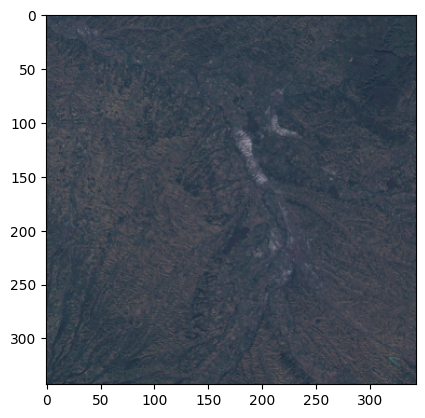

In [3]:
#affichons la donnée complete depuis une overview (=une version sous-echantillonnée précalculée)
#https://rasterio.readthedocs.io/en/stable/api/rasterio.io.html#rasterio.io.DatasetReader.read
with rio.open(s2_tile) as st:
    ovr = st.read(out_shape=(3,st.height//32,st.width//32))
    rp.show(ovr)

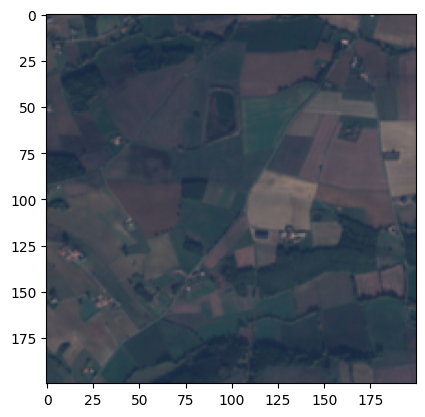

In [4]:
#affichons un extrait de 200x200px en pleine resolution
# https://rasterio.readthedocs.io/en/stable/api/rasterio.windows.html#rasterio.windows.Window
with rio.open(s2_tile) as st:
    extract = st.read(window=Window(5000,5000,200,200), out_shape=(3,200,200))
    rp.show(extract)



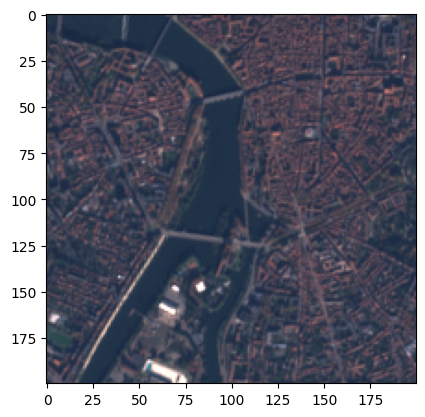

In [5]:
# affichons un extrait de 200x200px autour du centre de toulouse (longitude=1.4395871 latitude=43.5943521)
# https://pyproj4.github.io/pyproj/stable/examples.html#transformations-from-crs-to-crs
# https://github.com/rasterio/affine
from pyproj import CRS
from pyproj import Transformer
with rio.open(s2_tile) as st:
    transformer = Transformer.from_crs('EPSG:4326', st.crs) #EPSG:4326 is lat/lon
    utm_x, utm_y = transformer.transform(43.5943521,1.4395871)
    utm_to_pix = ~st.transform
    pix_x,pix_y = utm_to_pix*(utm_x,utm_y)
    extract = st.read(window=Window(pix_x-100,pix_y-100,200,200))
    rp.show(extract)